# Análise descritiva e preditiva de CHURN de cartão de crédito

A retençãode clientes é um dos maiores desafios. O ato de cancelar o cartão de crédito é chamado de evento de CHURN.

O objetivo da análise de CHURN presente nesse notebook é:
- Entender o cenário atual da base de associados que utilizam cartão de crédito e entram em CHURN

- Apresentar a primeiros resultados do modelo preditivo para apoiar nas ações de mitigação do CHURN de cartão de crédito

- Apresentar planejamento de próximos passos de ações do time de dados





# Informações sobre as bases de dados

A base de dados é composta pelos três arquivos descritos abaixo:


- `CBO2002 - Ocupacao.csv`: contém dados da [Classificação Brasileira de Opucpações (CBO)](https://empregabrasil.mte.gov.br/76/cbo/) que retrata a realidade das profissões do mercado de trabalho brasileiro com base na Portaria nº 397, de 10.10.2002. O CBO reconhece a existência da profissão mas na sua regulamentação.
- `cnae.xlsx`: contém dados da [Classificação Nacional de Atividades Econômicas (CNAE)](https://www.gov.br/receitafederal/pt-br/assuntos/orientacao-tributaria/cadastros/cnpj/classificacao-nacional-de-atividades-economicas-2013-cnae) que padroniza o código de atividades econicas.
- `case_mep_dados.xls`: a planilha contém várias abas que representam bases de dados como: cadastro de clientes e informações complementares, transações financeiras realizadas com o cartão de crédito, abertura de chamados e clientes que deram CHURN.


## Detalhamento das bases de dados extraídas desses arquivos

### Base de dados de CBO
| Atributo | Tipo | Descrição |
| -------- | ---- | --------- |
| CODIGO | INTEGER | Identificador do CBO |
| TITULO | STRING | Nome da profissão presentes na base do CBO |

### Base de dados de CNAE
| Atributo | Tipo | Descrição |
| -------- | ---- | --------- |
| cod_cnae | FLOAT | Identificador do CNAE |
| des_cnae | STRING | Descrição do CNAE |

### Base de dados analitico
| Atributo | Tipo | Descrição |
| -------- | ---- | --------- |
| id_cliente | INTEGER | Identificador do cliente |
| id_cliente_unmask | INTEGER | Identificador do cliente |
| idade | INTEGER | Idade do cliente |
| profissao | STRING | Profissão do cliente |
| sexo | STRING | Identificação do sexto do cliente (F ou M) |
| regiao_residencia | STRING | Região de residência do cliente |
| risco | STRING | Identificador do grau de risco de crédito |
| ultimos_2_meses_qtd_transacoes | INTEGER | Quantidade de transações financeiras realizadas nos últimos dois meses |
| ultimos_2_meses_vlr_transacoes | INTEGER | Valor das transações financeiras realizadas nos últimos dois meses |
| ultimos_2_meses_qtd_transacoes_41_42_43_45 | INTEGER | Quantidade de transações financeiras realizadas nos últimos dois meses classificadas como 41, 42, 43 e 45 |
| qtd_chamados_ultimos_3_meses_negativos | INTEGER | Quantidade de chamados negativos dos últimos três meses |

### Base de dados de cadastro
| Atributo | Tipo | Descrição |
| -------- | ---- | --------- |
| id_cliente_unmask | INTEGER | Identificador do cliente |
| id_associado | INTEGER | Identificador do cliente associado |
| idade | INTEGER | Idade do cliente |
| profissao | STRING | Profissão do cliente |
| sexo | STRING | Identificação do sexto do cliente (F ou M) |
| regiao_residencia | STRING | Região de residência do cliente |
| risco | STRING | Identificador do grau de risco de crédito |
| cliente_desde | DATETIME | Data que o cliente iniciou a relação com a instituição |


### Base de dados com o identificador dos clientes que deram CHURN no cartão de crédito
| Atributo | Tipo | Descrição |
| -------- | ---- | --------- |
| id_cliente | INTEGER | Identificador do cliente |
| id_cliente_unmask | INTEGER | Identificador do cliente |
| id_associado | INTEGER | Identificador do cliente associado |


### Base de dados de chamados
| Atributo | Tipo | Descrição |
| -------- | ---- | --------- |
| id_chamado | INTEGER | Identificador do chamado |
| id_chamado_unmask | INTEGER | Identificador do chamado |
| id_cliente_unmask | INTEGER | Identificador do cliente |
| data | DATETIME | Data que o chamado foi aberto |
| chamado_base | STRING | Tema do contato do cliente |
| chamado | STRING | Contém a conversa completa entre cliente associado e atendente |
| negativo | BOOLEAN | Identifica se o atendimento foi negativo, se sim será igual a 1.0 |

### Base de dados de transações financeiras realizadas com o cartão de crédito
| Atributo | Tipo | Descrição |
| -------- | ---- | --------- |
| id_transacao | FLOAT | Identificador da transação |
| id_transacao_unmask | INTEGER | Identificador da transação |
| id_associado_unmask | INTEGER | Identificador do cliente associado |
| id_associado | INTEGER | Identificador do cliente associado |
| data | DATETIME | Data da transação |
| tipo_estabelecimento | STRING | Tipo de estabelecimento em que a transação foi feita |
| cnae45 | INTEGER | CNAE (possivelmente do estabelecimento) em que a transação foi feita |
| valor | INTEGER | Valor da transação |
| online_presencial | STRING | Identifica se a transação foi feita de forma presncial ou online |



# Importação de bibliotecas

In [105]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from abc import ABC
from typing import Any, Union
from dataclasses import dataclass, field

import pickle
from pathlib import Path

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    precision_score,
    recall_score, 
    f1_score

)
from sklearn.metrics import ConfusionMatrixDisplay

import xgboost as xgb
import lightgbm as lgb
import catboost
import optuna

# Funções compartilhadas

### Funções para o pré-processamento dos dados analíticos

In [2]:
def get_df_min_max_date_action(df: pd.DataFrame, id:int='id_associado', col:str='data', min_col:str='data_min', max_col:str='data_max') -> pd.DataFrame:
    """
    Esta função tem por objetivo retornar um dataframe com a menor e maior data de uma ação por cliente.
    Por exemplo, menor e maior data de um chamado aberto por cliente ou menor e maior data de uma trasação do cliente.

    Args:
        df (pd.DataFrame): DataFrame que será utilizado.
        id (int, optional): Coluna identificadora para realizar o agrupamento dos dados. Defaults to 'id_associado'.
        col (str, optional): Nome da coluna de data que será observada. Defaults to 'data'.
        min_col (str, optional): Nome que será utilizado no rename da coluna do valor mínimo. Defaults to 'data_min'.
        max_col (str, optional): Nome que será utilizado no rename da coluna do valor máximo. Defaults to 'data_max'.

    Returns:
        df (pd.DataFrame): DataFrame com valores mínimos e máximos agrupados por identificador.
    """
    
    df = df.groupby(['id_associado']).agg({'data': ['min', 'max']})
    df = df.rename(columns={'min': min_col, 'max': max_col}, level=1)
    df.columns = df.columns.droplevel(0)
    df = df.reset_index()
    #df[f'data_inicio_{last_months}_ultimos_meses'] = df[max_col] - pd.offsets.MonthBegin(last_months)
    return df

def get_customer_since_time(df: pd.DataFrame) -> float:
    """
    Calcula quanto tempo o cliente na base. 
    Como não temos a informação da data do churn a aproximação da data é feita utilizada a data do último chamado e da última transação.
    Por padrão utiliza a data da última transação, mas caso a data do último chamado seja maior essa data é substituída pelo chamado.

    Args:
        df (pd.DataFrame): DataFrame utilizado.

    Returns:
        float: Tempo que o cliente está na base em dias.
    """
    
    field = 'data_ultima_transacao'
    if df['data_ultimo_chamado'] and df['data_ultimo_chamado'] > df['data_ultima_transacao']:
        field = 'data_ultimo_chamado'

    customer_since_in_days = (df[field] - df['cliente_desde']).days
    customer_since_in_months = (df[field].to_period('M') - df['cliente_desde'].to_period('M')).n
    customer_since_in_years = (df[field].to_period('Y') - df['cliente_desde'].to_period('Y')).n
    return [customer_since_in_days, customer_since_in_months, customer_since_in_years]

def process_string(df: pd.DataFrame, field: str) -> pd.Series:
    """
    Método responsável por aplicar tratamento no texto da profissão/CBO e CNAE.

    Args:
        df (pd.DataFrame): DataFrame utilizado
        field (str): Nome do atributo que receberá o tratamento.

    Returns:
        pd.Series: Coluna de texto tratada.
    """

    return df[field].str.split().str.join('').str.replace(r'[\(|\)|,|-]', '', regex=True)


def get_cbo_code(profession: str) -> int:
    """
    Método responsável por retornar o código do CBO conforme a profissão informada.

    Args:
        profession (str): Profissão.

    Returns:
        int: Código do CBO.
    """
    return df_cbo.loc[(df_cbo['TITULO'] == profession) | (df_cbo['TITULO_JOIN'] == profession)]['CODIGO'].values[0]

def get_cnae_code(description: str) -> int:
    """
    Método responsável por retornar o código do CNAE de acordo com a descrição do estabelicimento.

    Args:
        description (str): Descrição do estabelecimento.

    Returns:
        int: Código CNAE.
    """
    return df_cnae.loc[(df_cnae['des_cnae'] == description)]['cod_cnae'].values[0]

### Definição das classes que prepararam os dados para o classificador
- Implementa classe para realizar o tratamento do OneHotEnconde
- Implementa classe para realizar a normalização dos dados
- Impementa classe para realizar a análise de PCAs

In [3]:
PATH_MODELS = "."
EXTENSION = 'pkl'

@dataclass
class FitTransform(ABC):
    """
    Classe abstrata para realizar o treinamento e transformação de atributos, 
    incluindo o salvamento e carregamento do modelo pré-treinado.
    """

    model: Any = field(init=False, default=None)
    
    def fit(self, df):
        """
        Método que realiza o treinamento do modelo.
        """

        pass
    
    def transform(self, df):
        """
        Método que realiza a transoformação dos dados conforme o modelo pré-treinado.
        """
        pass

    def save(self, filename):
        """
        Método que salva o arquivo do modelo pré-treinado.
        """

        filepath = Path(PATH_MODELS, f"{filename}.{EXTENSION}")
        with open(filepath, 'wb') as file:
            pickle.dump(self.model, file)
        return self
    
    def load(self, filename):
        """
        Método que carrega o arquivo do modelo pré-treinado.
        """
        filepath = Path(PATH_MODELS, f"{filename}.{EXTENSION}")
        self.model = pd.read_pickle(filepath)
        
        return self

@dataclass
class CustomOneHotEncoder(FitTransform):
    """
    Classe que implementa métodos para realizar o treinamento e a aplicação do
    OneHotEncode dos dados categóricos.
    """
    
    def fit(self, df):
        """
        Método que realiza o treinamento do modelo.
        """
        self.model = OneHotEncoder(handle_unknown='ignore')
        self.model.fit(df)
        return self
    
    def transform(self, df):
        """
        Método que realiza a transoformação dos dados conforme o modelo pré-treinado.
        """

        print(f'Categories: {self.model.categories_}')
        new_cols = list(self.model.get_feature_names_out(list(df.columns)))
        data = self.model.transform(df).toarray()
        df_encode = pd.DataFrame(data, columns=new_cols)
        return df_encode

@dataclass
class CustomScaler(FitTransform):
    """
    Classe que implementa métodos para realizar o treinamento e a aplicação do
    da normalização dos dados.
    """

    def fit(self, df, scaler_cls):
        """
        Método que realiza o treinamento do modelo.
        """
        self.model = scaler_cls()
        self.model.fit(df)
        return self
    
    def transform(self, df):
        """
        Método que realiza a transoformação dos dados conforme o modelo pré-treinado.
        """
        columns = list(df.columns)
        transformed = self.model.transform(df)
        return pd.DataFrame(transformed, columns=columns)

@dataclass
class CustomPCA(FitTransform):   
    def fit(self, X, n_components=None):
        """
        Método que realiza o treinamento do modelo.
        """

        self.model = PCA(svd_solver="full", n_components=n_components)
        self.model.fit(X)
        return self
       
    def transform(self, df):
        """
        Método que realiza a transoformação dos dados conforme o modelo pré-treinado.
        """

        transformed = self.model.transform(df)
        n_components = transformed.shape[1]
        columns = [f"pcas_{i}" for i in range(n_components)]
        return pd.DataFrame(transformed, columns=columns)
    
    def get_n_components(self, cumulative_ratio_limit=0.98):
        """
        Método retorna o número de componentes principais conforme parâmetros informados.
        """

        cumulative_variance_ratio = np.cumsum(self.model.explained_variance_ratio_)
        return np.argmax(cumulative_variance_ratio >= cumulative_ratio_limit)
    
    def plot_pca(self, df):
        """
        Método plota o gráfico de análise das componentes principais.
        """

        # Individual explained variances for 10 components
        individual_variances = self.model.explained_variance_ratio_

        # Compute the cumulative explained variance
        cumulative_variances = np.cumsum(self.model.explained_variance_ratio_)

        # Create the bar plot for individual variances
        plt.figure(figsize=(12, 7))
        bar = plt.bar(range(1, len(df.columns)+1), individual_variances, alpha=0.6, color='g', label='% de explicabilidade')

        # Create the line plot for cumulative variance
        line = plt.plot(range(1, len(df.columns)+1), cumulative_variances, marker='o', linestyle='-', color='r', 
                        label='% cumulativo')

        # Adding percentage values on top of bars and dots
        for i, (bar, cum_val) in enumerate(zip(bar, cumulative_variances)):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{individual_variances[i]*100:.1f}%', 
                     ha='center', va='bottom')
            plt.text(i+1, cum_val, f'{cum_val*100:.1f}%', ha='center', va='bottom')

        # Aesthetics for the plot
        plt.xlabel('N° de componentes principais')
        plt.ylabel('% de explicabilidade')
        plt.title('Análise de Componentes Principais (PCA)')
        plt.xticks(range(1, len(df.columns)+1))
        plt.legend(loc='upper left')
        plt.ylim(0, 1.1)  # extend y-axis limit to accommodate text labels
        plt.grid(True)
        plt.show()

### Definição do objeto ClassifierOptimizerMultiObjective que busca otimizar a acurácia, precision, recall e f1 score

A estrutura **multi objetive** busca otimizar mais de uma métrica de avaliação de desempenho dos modelos.

Aqui estamos implementando a classe `ClassifierOptimizerMultiObjective` que encapsula a utilização do optuna e o treinamento do modelo com melhor desempenho para a acurácia, precision, recall e f1 score da tarefa de classificação do dataset da análise preditiva de CHURN do cartão de crédito.

Para o pipeline de treinamento foram considerados os seguintes algoritmos de machine learning:
- Regressão Logística
- SVM
- Árvore de decisão
- RandomForest
- LightGBM
- CatBoost

O optuna irá retornar o modelo que tiver o melhor desempenho.

O pipeline de otimização de hiperparâmetros com o Optuna poderia ter sido trabalhado em conjunto com o MLFlow para fazer o tracking das métricas a fim de comparar o melhor modelo com os demais. Mas esse ponto será tratado em uma próxima versão.

In [4]:
class ClassifierOptimizerMultiObjective:
    """
    Classe responsável por treinar multiplos modelos, otimizando os hiperparâmetros
    e retornar o modelo com a melhor performance.
    """

    def __init__(
        self,
        n_trials: int = 500,
        timeout: int = 600,
        n_jobs: int = -1,
        k_folds: int = 5,
        study_name: str = 'classifier_muiltiple_objective_study',
        db_storage: str = 'sqlite:///classifier_muiltiple_objective_study.sqlite3',
    ) -> None:
        self.n_trials = n_trials
        self.timeout = timeout
        self.n_jobs = n_jobs
        self.k_folds = k_folds
        self.study_name = study_name
        self.db_storage = db_storage
        self._study = self._study_load_or_create()
        self._best_model = None

    def _study_load_or_create(self):
      """
      Método responsável por carregar e criar o estudo do optuna.
      """
      
      study = optuna.create_study(
          study_name=self.study_name, 
          storage=self.db_storage, 
          load_if_exists=True,
          directions=['maximize', 'maximize', 'maximize', 'maximize']
      )
      return study

    def get_study(self):
      """
      Método responsável por retornar o objeto estudo do optuna.
      """

      return self._study

    def fit(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
    ):
        """
        Método responsável por retornar o melhor modelo treinado.

        Arguments:
            X -- X values

            y -- y target

        Returns:
            Melhor modelo treinado.
        """

        # Study optimize function
        self._study_optimizer(X, y)
        self._best_model = self._classifier_fit_best_model(X, y)
        return self._best_model
 
    def _study_optimizer(
        self,
        X: pd.DataFrame,
        y: pd.DataFrame,
    ):
        """
        Método responsável por chamar a otimização do classificador para encontrar
        o melhor modelo com os melhores hiperparâmetros.

        Arguments:
            X -- X values

            y -- y target

        Returns:
            Objeto estudo do optuna.
        """
        
        # Wrap the objective inside a lambda and call objective inside it
        objective_wrap_func = lambda trial: self._objective(
            trial, X, y
        )

        # Invoke optimization of the objective function.
        self._study.optimize(
            objective_wrap_func,
            n_trials=self.n_trials,
            timeout=self.timeout,
            n_jobs=self.n_jobs,
        )
        return self

    def _objective(
        self,
        trial: optuna.Trial,
        X: pd.DataFrame,
        y: pd.DataFrame,
    ) -> float:
        """
        Função objetivo responsável por maximizar as métricas do modelos de classificação
        com diferentes configurações de hiperparâmetros.

        Arguments:
            trial -- Objeto trial do optuna.

            X -- X values

            y -- y target

        Returns:
            Média das métricas do classificador
        """

        random_state = 42
        classifier_name = trial.suggest_categorical(
            "classifier",
            [
                "LR"
                "SVC", 
                "DecisionTreeClassifier",
                "RandomForest",
                "LightGBM",
                "Catboost"
            ],
        )
        classifier_obj = None
        if classifier_name == "LR":
            classifier_obj = LogisticRegression(random_state=random_state)
        elif classifier_name == "SVC":
            classifier_obj = SVC(probability=True, random_state=random_state)
        elif classifier_name == "DecisionTreeClassifier":
            classifier_obj = DecisionTreeClassifier(
                max_depth=trial.suggest_int("dtc_max_depth", 2, 300),
                min_samples_split=trial.suggest_int(
                    "dtc_min_samples_split", 2, 65
                ),
                min_samples_leaf=trial.suggest_int(
                    "dtc_min_samples_leaf", 1, 16
                ),
                min_weight_fraction_leaf=trial.suggest_float(
                    "dtc_min_weight_fraction_leaf", 0.0, 0.1
                ),
                max_features=trial.suggest_categorical(
                    "dtc_max_features", [None, "auto", "sqrt", "log2"]
                ),
                criterion=trial.suggest_categorical(
                    "dtc_criterion", ["gini", "entropy"]
                ),
                splitter=trial.suggest_categorical(
                    "dtc_splitter", ["best", "random"]
                ),
                random_state=random_state
            )
        elif classifier_name == "RandomForest":
            classifier_obj = RandomForestClassifier(
                n_estimators=trial.suggest_int("rf_n_estimators", 2, 256),
                max_depth=trial.suggest_int("rf_max_depth", 2, 128),
                min_samples_split=trial.suggest_int(
                    "rf_min_samples_split", 2, 64
                ),
                min_samples_leaf=trial.suggest_int(
                    "rf_min_samples_leaf", 1, 16
                ),
                max_features=trial.suggest_categorical(
                "rf_max_features", ["sqrt", "log2", None]
                ),
                min_weight_fraction_leaf=trial.suggest_float(
                    "rf_min_weight_fraction_leaf", 1e-5, 0.03, log=True
                ),
                max_samples=trial.suggest_float("rf_max_samples", 0.8, 1.0),
                criterion=trial.suggest_categorical(
                    "rf_criterion", ["gini", "entropy"]
                ),
                random_state=random_state
            )
        elif classifier_name == "LightGBM":
            classifier_obj = lgb.LGBMClassifier(
                boosting_type=trial.suggest_categorical(
                    "lg_boosting_type", ["gbdt"]
                ),
                num_leaves=trial.suggest_int("lg_num_leaves", 16, 128),
                max_depth=trial.suggest_int("lg_max_depth", 2, 128),
                learning_rate=trial.suggest_float(
                    "lg_learning_rate", 5e-3, 2e-1
                ),
                n_estimators=trial.suggest_int("lg_n_estimators", 2, 256),
                min_child_samples=trial.suggest_int(
                    "lg_min_child_samples", 1, 32
                ),
                colsample_bytree=trial.suggest_float(
                    "lg_colsample_bytree", 0.8, 1.0
                ),
                random_state=random_state
            )
        elif classifier_name == "Catboost":
            classifier_obj =  catboost.CatBoostClassifier(
                iterations=trial.suggest_int("iterations", 100, 1000),
                learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
                depth=trial.suggest_int("depth", 4, 10),
                l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
                bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
                random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
                bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
                od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
                od_wait=trial.suggest_int("od_wait", 10, 50),                
            )

        if not classifier_obj:
            return 0, 0, 0, 0
            
        cv = self.k_folds
        scores = cross_validate(
            classifier_obj,
            X,
            y.values.ravel(),
            cv=cv,
            scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
            return_train_score=True,
            n_jobs=-1,
        )
     
        accuracy = np.mean(scores['test_accuracy'])
        precision = np.mean(scores['test_precision_macro'])
        recall = np.mean(scores['test_recall_macro'])
        f1 = np.mean(scores['test_f1_macro'])

        return accuracy, precision, recall, f1


    def _classifier_fit_best_model(
        self, X: pd.DataFrame, y: pd.DataFrame
    ) -> Union[
        SVC, DecisionTreeClassifier, RandomForestClassifier, lgb.LGBMClassifier
    ]:
        """
        Método responsável por treinar o modelo com a melhor performance encontrada
        no estudo da otimização.

        Arguments:
            X -- X values

            y -- y target

        Returns:
            Melhor modelo pré treinado.
        """
        
        random_state=42
        y = y.values.ravel()
        best_params = self._study.best_trials[0].params
        best_model_name = best_params["classifier"]
        best_model = None
        
        if best_model_name == "LR":
            best_model = LogisticRegression(random_state=random_state)
        elif best_model_name == "SVC":
            best_model = SVC(probability=True, random_state=random_state).fit(X, y)
        elif best_model_name == "DecisionTreeClassifier":
            best_model = DecisionTreeClassifier(
                max_depth=best_params["dtc_max_depth"],
                min_samples_split=best_params["dtc_min_samples_split"],
                min_samples_leaf=best_params["dtc_min_samples_leaf"],
                min_weight_fraction_leaf=best_params[
                    "dtc_min_weight_fraction_leaf"
                ],
                max_features=best_params["dtc_max_features"],
                criterion=best_params["dtc_criterion"],
                splitter=best_params["dtc_splitter"],
                random_state=random_state
            )
        elif best_model_name == "RandomForest":
            best_model = RandomForestClassifier(
                n_estimators=best_params["rf_n_estimators"],
                max_depth=best_params["rf_max_depth"],
                min_samples_split=best_params["rf_min_samples_split"],
                min_samples_leaf=best_params["rf_min_samples_leaf"],
                max_features=best_params["rf_max_features"],
                min_weight_fraction_leaf=best_params[
                    "rf_min_weight_fraction_leaf"
                ],
                max_samples=best_params["rf_max_samples"],
                criterion=best_params["rf_criterion"],
                random_state=random_state
            ).fit(X, y)
        elif best_model_name == "LightGBM":
            best_model = lgb.LGBMClassifier(
                boosting_type=best_params["lg_boosting_type"],
                num_leaves=best_params["lg_num_leaves"],
                max_depth=best_params["lg_max_depth"],
                learning_rate=best_params["lg_learning_rate"],
                n_estimators=best_params["lg_n_estimators"],
                min_child_samples=best_params["lg_min_child_samples"],
                colsample_bytree=best_params["lg_colsample_bytree"],
                random_state=random_state
            ).fit(X, y)
        elif best_model_name ==  "Catboost":
            best_model =  catboost.CatBoostClassifier(
                iterations=best_params["iterations"],
                learning_rate=best_params["learning_rate"],
                depth=best_params["depth"],
                l2_leaf_reg=best_params["l2_leaf_reg"],
                bootstrap_type=best_params["bootstrap_type"],
                random_strength=best_params["random_strength"],
                bagging_temperature=best_params["bagging_temperature"],
                od_type=best_params["od_type"],
                od_wait=best_params["od_wait"],
            ).fit(X, y)

        return best_model


# Leitura dos arquivos utilizados e preparação das base de dados analítica/preditiva

In [6]:
# Definição de variáveis globais que contém o caminho para os arquivos utilizados

CBO_PATH = "../data/raw/CBO2002 - Ocupacao.csv"
CNAE_PATH = "../data/raw/cnae.xlsx"
CASE_MEP_DADOS_PATH = "../data/raw/case_mep_dados.xlsx"

## Leitura e tratamento do arquivo com dados de CBO

Antes de iniciar o processo de leitura do arquivo com o python, foi necessário abrir localmente com LibreOffice e salvá-lo no formato ISO-8859-1, pois o pandas não estava conseguindo fazer as conversões necessárias para a leitura adequada. O arquivo presente nesse projeto já está convertido. Caso você tenha algum problema na execussão desse notebook verifique a formação do arquivo.

O arquivo possui algumas colunas adicionais com texto, nem todos os registros estão preenchidos. Para não perder dados nessa primeira etapa, foi criada uma coluna adicional no dataframe chamada TITULO_JOIN que contém o texto concatenado das colunas TITULO com as colunas adicionais não nomeadas.

In [7]:
df_cbo = pd.read_csv(CBO_PATH, encoding="ISO-8859-1", engine='python').dropna(how='all', axis='columns')
columns_join = list(df_cbo.columns)[1::]
df_cbo['TITULO_JOIN'] = df_cbo[columns_join].fillna('').apply(lambda row:' '.join(row.values.astype(str)), axis=1)
df_cbo['TITULO'] = process_string(df_cbo, 'TITULO')
df_cbo['TITULO_JOIN'] = process_string(df_cbo, 'TITULO_JOIN')
display(df_cbo.info())
df_cbo.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CODIGO       2694 non-null   int64 
 1   TITULO       2694 non-null   object
 2   Unnamed: 2   121 non-null    object
 3   Unnamed: 3   17 non-null     object
 4   Unnamed: 4   6 non-null      object
 5   Unnamed: 5   4 non-null      object
 6   Unnamed: 6   1 non-null      object
 7   TITULO_JOIN  2694 non-null   object
dtypes: int64(1), object(7)
memory usage: 168.5+ KB


None

,CODIGO,TITULO,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,TITULO_JOIN
0,10105,Oficialgeneraldaaeronáutica,NaN,NaN,NaN,NaN,NaN,Oficialgeneraldaaeronáutica


In [8]:
df_cbo

,CODIGO,TITULO,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,TITULO_JOIN
0,10105,Oficialgeneraldaaeronáutica,NaN,NaN,NaN,NaN,NaN,Oficialgeneraldaaeronáutica
1,10110,Oficialgeneraldoexército,NaN,NaN,NaN,NaN,NaN,Oficialgeneraldoexército
2,10115,Oficialgeneraldamarinha,NaN,NaN,NaN,NaN,NaN,Oficialgeneraldamarinha
3,10205,Oficialdaaeronáutica,NaN,NaN,NaN,NaN,NaN,Oficialdaaeronáutica
4,10210,Oficialdoexército,NaN,NaN,NaN,NaN,NaN,Oficialdoexército
...,...,...,...,...,...,...,...,...
2689,992205,Encarregadogeraldeoperaçõesdeconservaçãodevias...,NaN,NaN,NaN,NaN,NaN,Encarregadogeraldeoperaçõesdeconservaçãodevias...
2690,992210,Encarregadodeequipedeconservaçãodeviaspermanen...,NaN,NaN,NaN,NaN,NaN,Encarregadodeequipedeconservaçãodeviaspermanen...
2691,992215,Operadordeceifadeiranaconservaçãodeviaspermane...,NaN,NaN,NaN,NaN,NaN,Operadordeceifadeiranaconservaçãodeviaspermane...
2692,992220,Pedreirodeconservaçãodeviaspermanentesexcetotr...,NaN,NaN,NaN,NaN,NaN,Pedreirodeconservaçãodeviaspermanentesexcetotr...


## Leitura e tratamento do arquivo com dados de CNAE

In [9]:
xlsx_cnae = pd.ExcelFile(CNAE_PATH)
sheet_name = 'result'
df_cnae = pd.read_excel(xlsx_cnae, sheet_name).dropna(how='all', axis=0)
df_cnae['des_cnae'] = process_string(df_cnae, 'des_cnae')
display(df_cnae.info())
df_cnae.head(1)

<class 'pandas.core.frame.DataFrame'>
Index: 1324 entries, 1 to 1324
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cod_cnae  1324 non-null   float64
 1   des_cnae  1324 non-null   object 
dtypes: float64(1), object(1)
memory usage: 31.0+ KB


None

,cod_cnae,des_cnae
1,111301.0,CULTIVODEARROZ


## Leitura da planilha case_mep_dados.xlsx com dados dos clientes para a análise de CHURN

- Durante a leitura da aba `analitico` percebi que existem colunas não nomeadas com apenas 1 registro preenchido com uma data. Como só 1 registro possui esse dado, acabei optando por remover do dataframe, pois nesse momento não irá agregar na análise.

- Durante a leitura da aba `churn`, identifiquei uma coluna não nomeada que parece conter dados do `id_associado`. Por isso, faço o rename da coluna no momente em que estou lendo o arquivo.

In [10]:
xlsx_case = pd.ExcelFile(CASE_MEP_DADOS_PATH)
df_analitico = pd.read_excel(xlsx_case, sheet_name='analitico').dropna(how='all', axis='columns')
df_analitico = df_analitico.loc[:,~df_analitico.columns.str.contains('^Unnamed', case=False)] 

df_cadastro = pd.read_excel(xlsx_case, sheet_name='cadastro').dropna(how='all', axis='columns')
df_churn = pd.read_excel(xlsx_case, sheet_name='churn').dropna(how='all', axis='columns').rename(columns={'Unnamed: 2': 'id_associado'})
df_chamados = pd.read_excel(xlsx_case, sheet_name='chamados').dropna(how='all', axis='columns')
df_transacional = pd.read_excel(xlsx_case, sheet_name='transacional').dropna(how='all', axis='columns')

Como a data do CHURN não foi fornecida, e temos a data que o cliente iniciou na base, gostaria de ter uma ideia de quanto tempo o cliente está na base. Pensei em estimar o tempo de permanência do cliente na base a partir da diferença da data presente no atributo `cliente_desde` e as maior data entre `data_ultimo_chamado` e `data_ultima_transacao`. Para isso, foi necessário obter a data do último chamado e da última transação por cliente, conforme os dataframes abaixo. Mais pra frente esses dataframes serão utilizados no dataframe que consolida todos os dados para a análise preditiva do CHURN.

In [11]:
df_chamados_min_max_date = get_df_min_max_date_action(df_chamados, min_col='data_primeiro_chamado', max_col='data_ultimo_chamado')
print('DataFrame das datas máximas e mínimas de chamados abertos por cliente')
display(df_chamados_min_max_date.head(1))

df_transacional_min_max_date = get_df_min_max_date_action(df_transacional, min_col='data_primeira_transacao', max_col='data_ultima_transacao')
print('DataFrame das datas máximas e mínimas de transações realizadas por cliente')
display(df_transacional_min_max_date.head(1))

DataFrame das datas máximas e mínimas de chamados abertos por cliente


,id_associado,data_primeiro_chamado,data_ultimo_chamado
0,81482133,2023-11-14,2023-11-14


DataFrame das datas máximas e mínimas de transações realizadas por cliente


,id_associado,data_primeira_transacao,data_ultima_transacao
0,81482133,2023-07-25,2023-11-11


### Entendendo o conteúdo da base de chamados


In [12]:
df_chamados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_chamado         366 non-null    int64         
 1   id_chamado_unmask  366 non-null    int64         
 2   id_cliente_unmask  366 non-null    int64         
 3   id_associado       366 non-null    int64         
 4   data               366 non-null    datetime64[ns]
 5   chamado_base       366 non-null    object        
 6   chamado            366 non-null    object        
 7   negativo           121 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 23.0+ KB


In [13]:
df_chamados.iloc[0]['chamado_base']

'Associado: Olá, gostaria de pagar minha fatura de cartão de crédito. Atendente: Claro, qual é o número do seu cartão?'

In [14]:
df_chamados.iloc[0]['chamado']

'Atendente: Estamos passando por instabilidades, o atendimento poderá demorar mais que o normal. Associado: Olá, gostaria de pagar minha fatura de cartão de crédito. Atendente: Claro, qual é o número do seu cartão? Associado: Você não consegue ver no sistema? Não vou passar nenhuma informação. Atendente: Infelizmente não. Associado: Frustrante. Atendente: Precisarei encerrar o chamado devido a falta de resposta.'

In [15]:
df_chamados = pd.merge(df_chamados, df_chamados_min_max_date[['id_associado', 'data_ultimo_chamado']], on=['id_associado'], how="left")
df_chamados.head(1)

,id_chamado,id_chamado_unmask,id_cliente_unmask,id_associado,data,chamado_base,chamado,negativo,data_ultimo_chamado
0,69581,1,1,81485435,2023-12-10,"Associado: Olá, gostaria de pagar minha fatura...",Atendente: Estamos passando por instabilidades...,1.0,2023-12-10


In [16]:
df_chamados.loc[((df_chamados['data_ultimo_chamado'] - df_chamados['data']).dt.days <= 90)].groupby(['id_associado']).agg({
    'negativo': 'sum',
    'id_chamado': 'count'
})

,negativo,id_chamado
id_associado,,
81482133,0.0,2
81482170,0.0,1
81482193,0.0,1
81482209,0.0,1
81482251,0.0,1
...,...,...
99952795,1.0,1
99952800,1.0,1
99952801,1.0,1


### Entendendo o conteúdo da base transacional


In [17]:
df_transacional

,id_transacao,id_transacao_unmask,id_associado_unmask,id_associado,data,tipo_estabelecimento,cnae45,valor,online_presencial
0,5.530269e+04,1,1,81485435,2023-11-25,RECUPERACAO DE MATERIAIS NAO ESPECIFICADOS ANT...,0,64,Online
1,5.630369e+04,2,1,81485435,2023-12-05,COMERCIO POR ATACADO DE CAMINHOES NOVOS E USADOS,1,181,Online
2,1.444047e+05,3,1,81485435,2023-12-13,ADMINISTRACAO DE OBRAS,1,855,Online
3,5.539469e+04,4,1,81485435,2023-10-25,PRODUCAO DE FORJADOS DE ACO,0,16,Presencial
4,1.047647e+06,5,1,81485435,2023-12-19,SERVICOS ESPECIALIZADOS PARA CONSTRUCAO NAO ES...,1,176,Presencial
...,...,...,...,...,...,...,...,...,...
15814,7.314469e+04,15815,939,99952385,2023-12-04,CRIACAO DE JACARE,0,4,Online
15815,7.224069e+04,15816,124,99951945,2023-06-09,EXTRACAO DE MINERIOS DE NIOBIO E TITANIO,0,231,Presencial
15816,7.259869e+04,15817,262,81483261,2023-11-11,MANUTENCAO E REPARACAO DE MAQUINAS PARA A INDU...,0,65,Online
15817,7.284169e+04,15818,1082,99951561,2023-08-15,CRIACAO DE JACARE,0,67,Presencial


In [18]:
df_transacional['tipo_estabelecimento_ajustado'] = process_string(df_transacional, 'tipo_estabelecimento')
df_transacional['cod_cnae'] = df_transacional['tipo_estabelecimento_ajustado'].apply(get_cnae_code)
df_transacional

,id_transacao,id_transacao_unmask,id_associado_unmask,id_associado,data,tipo_estabelecimento,cnae45,valor,online_presencial,tipo_estabelecimento_ajustado,cod_cnae
0,5.530269e+04,1,1,81485435,2023-11-25,RECUPERACAO DE MATERIAIS NAO ESPECIFICADOS ANT...,0,64,Online,RECUPERACAODEMATERIAISNAOESPECIFICADOSANTERIOR...,3839499.0
1,5.630369e+04,2,1,81485435,2023-12-05,COMERCIO POR ATACADO DE CAMINHOES NOVOS E USADOS,1,181,Online,COMERCIOPORATACADODECAMINHOESNOVOSEUSADOS,4511104.0
2,1.444047e+05,3,1,81485435,2023-12-13,ADMINISTRACAO DE OBRAS,1,855,Online,ADMINISTRACAODEOBRAS,4399101.0
3,5.539469e+04,4,1,81485435,2023-10-25,PRODUCAO DE FORJADOS DE ACO,0,16,Presencial,PRODUCAODEFORJADOSDEACO,2531401.0
4,1.047647e+06,5,1,81485435,2023-12-19,SERVICOS ESPECIALIZADOS PARA CONSTRUCAO NAO ES...,1,176,Presencial,SERVICOSESPECIALIZADOSPARACONSTRUCAONAOESPECIF...,4399199.0
...,...,...,...,...,...,...,...,...,...,...,...
15814,7.314469e+04,15815,939,99952385,2023-12-04,CRIACAO DE JACARE,0,4,Online,CRIACAODEJACARE,322106.0
15815,7.224069e+04,15816,124,99951945,2023-06-09,EXTRACAO DE MINERIOS DE NIOBIO E TITANIO,0,231,Presencial,EXTRACAODEMINERIOSDENIOBIOETITANIO,729401.0
15816,7.259869e+04,15817,262,81483261,2023-11-11,MANUTENCAO E REPARACAO DE MAQUINAS PARA A INDU...,0,65,Online,MANUTENCAOEREPARACAODEMAQUINASPARAAINDUSTRIAME...,3314718.0
15817,7.284169e+04,15818,1082,99951561,2023-08-15,CRIACAO DE JACARE,0,67,Presencial,CRIACAODEJACARE,322106.0


In [19]:
df_transacional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id_transacao                   15819 non-null  float64       
 1   id_transacao_unmask            15819 non-null  int64         
 2   id_associado_unmask            15819 non-null  int64         
 3   id_associado                   15819 non-null  int64         
 4   data                           15819 non-null  datetime64[ns]
 5   tipo_estabelecimento           15819 non-null  object        
 6   cnae45                         15819 non-null  int64         
 7   valor                          15819 non-null  int64         
 8   online_presencial              15819 non-null  object        
 9   tipo_estabelecimento_ajustado  15819 non-null  object        
 10  cod_cnae                       15819 non-null  float64       
dtypes: datetime64[n

In [20]:
df_transacional = pd.merge(df_transacional, df_transacional_min_max_date[['id_associado', 'data_ultima_transacao']], on=['id_associado'], how="left")
df_transacional.head(1)

,id_transacao,id_transacao_unmask,id_associado_unmask,id_associado,data,tipo_estabelecimento,cnae45,valor,online_presencial,tipo_estabelecimento_ajustado,cod_cnae,data_ultima_transacao
0,55302.692295,1,1,81485435,2023-11-25,RECUPERACAO DE MATERIAIS NAO ESPECIFICADOS ANT...,0,64,Online,RECUPERACAODEMATERIAISNAOESPECIFICADOSANTERIOR...,3839499.0,2023-12-19


In [21]:
df_transacional.loc[((df_transacional['data_ultima_transacao'] - df_transacional['data']).dt.days <= 60)].groupby(['id_associado']).agg({
    'valor': 'sum',
    'id_transacao': 'count'
})

,valor,id_transacao
id_associado,,
81482133,1095,8
81482143,688,4
81482161,125,2
81482162,357,4
81482170,877,7
...,...,...
99952795,1416,5
99952800,1664,7
99952801,1725,8


In [22]:
df_transacional.loc[((df_transacional['data_ultima_transacao'] - df_transacional['data']).dt.days <= 60)].groupby(['id_associado', 'online_presencial']).agg({
    'valor': 'sum',
    'id_transacao': 'count'
}).head(20)

valor  id_transacao
id_associado online_presencial                     
81482133     Online               745             3
             Presencial           350             5
81482143     Online               543             3
             Presencial           145             1
81482161     Online               117             1
             Presencial             8             1
81482162     Online               133             2
             Presencial           224             2
81482170     Online               415             3
             Presencial           462             4
81482190     Presencial           291             3
81482193     Online               721             6
81482200     Online               670             6
             Presencial           287             2
81482209     Online               327             5
             Presencial           544             2
81482213     Online               875             5
             Presencial           299             1
81482231     Online               562             4
             Presencial           141             2

In [23]:
df_transacional.loc[((df_transacional['data_ultima_transacao'] - df_transacional['data']).dt.days <= 60)].groupby(['id_associado', 'tipo_estabelecimento']).agg({
    'valor': 'sum',
    'id_transacao': 'count'
}).head(20)

valor  \
id_associado tipo_estabelecimento                                        
81482133     COMERCIO ATACADISTA DE ARTIGOS DO VESTUARIO E A...    189   
             COMERCIO VAREJISTA ESPECIALIZADO DE EQUIPAMENTO...     82   
             CONFECCAO DE PECAS DO VESTUARIO, EXCETO ROUPAS ...    477   
             CONSERVACAO DE FLORESTAS NATIVAS                       10   
             FABRICACAO DE CHASSIS COM MOTOR PARA AUTOMOVEIS...     52   
             FABRICACAO DE FIOS, CABOS E CONDUTORES ELETRICO...     67   
             OBRAS DE ACABAMENTO EM GESSO E ESTUQUE                 17   
             SERVICOS DE TRATAMENTO E REVESTIMENTO EM METAIS       201   
81482143     CONSTRUCAO DE EMBARCACOES PARA ESPORTE E LAZER          8   
             INSTALACAO DE EQUIPAMENTOS PARA ORIENTACAO A NA...    371   
             MOAGEM DE TRIGO E FABRICACAO DE DERIVADOS             164   
             OBRAS DE IRRIGACAO                                    145   
81482161     BENEFICIAMENTO DE GESSO E CAULIM ASSOCIADO A EX...    117   
             CULTIVO DE ALHO                                         8   
81482162     CULTIVO DE ALGODAO HERBACEO                           128   
             FABRICACAO DE ARTEFATOS DE FIBROCIMENTO PARA US...     34   
             FABRICACAO DE MEDICAMENTOS ALOPATICOS PARA USO ...      5   
             FABRICACAO DE PRODUTOS QUIMICOS ORGANICOS NAO E...    190   
81482170     APARELHAMENTO DE PLACAS E EXECUCAO DE TRABALHOS...    367   
             CULTIVO DE ACACIA-NEGRA                               143   

                                                                 id_transacao  
id_associado tipo_estabelecimento                                              
81482133     COMERCIO ATACADISTA DE ARTIGOS DO VESTUARIO E A...             1  
             COMERCIO VAREJISTA ESPECIALIZADO DE EQUIPAMENTO...             1  
             CONFECCAO DE PECAS DO VESTUARIO, EXCETO ROUPAS ...             1  
             CONSERVACAO DE FLORESTAS NATIVAS                               1  
             FABRICACAO DE CHASSIS COM MOTOR PARA AUTOMOVEIS...             1  
             FABRICACAO DE FIOS, CABOS E CONDUTORES ELETRICO...             1  
             OBRAS DE ACABAMENTO EM GESSO E ESTUQUE                         1  
             SERVICOS DE TRATAMENTO E REVESTIMENTO EM METAIS                1  
81482143     CONSTRUCAO DE EMBARCACOES PARA ESPORTE E LAZER                 1  
             INSTALACAO DE EQUIPAMENTOS PARA ORIENTACAO A NA...             1  
             MOAGEM DE TRIGO E FABRICACAO DE DERIVADOS                      1  
             OBRAS DE IRRIGACAO                                             1  
81482161     BENEFICIAMENTO DE GESSO E CAULIM ASSOCIADO A EX...             1  
             CULTIVO DE ALHO                                                1  
81482162     CULTIVO DE ALGODAO HERBACEO                                    1  
             FABRICACAO DE ARTEFATOS DE FIBROCIMENTO PARA US...             1  
             FABRICACAO DE MEDICAMENTOS ALOPATICOS PARA USO ...             1  
             FABRICACAO DE PRODUTOS QUIMICOS ORGANICOS NAO E...             1  
81482170     APARELHAMENTO DE PLACAS E EXECUCAO DE TRABALHOS...             1  
             CULTIVO DE ACACIA-NEGRA                                        1

### Manipulação e junção das bases de dados

1. Estou iniciando com a junção dos dados da aba `analitico` com a de `cadastro` para complementar a base analítica com os atributos `id_associado` e `cliente_desde`. Essa junção é feita a partir do atributo que ambos os dataframes tem em comum, o `id_cliente_unmask`. Ambos os dataframes possuem a mesma quantidade de registros. 


2. Na sequência faço a junção dos dados com as informações da aba `churn` para complementar a base com um novo atributo booleando `is_churn` para identificar se o cliente deu churn ou não.Caso o identificado do cliente `id_cliente` esteja presente na aba `churn` significa que o cliente deu churn e o atributo `is_churn` será igual a `True`.

3. Na sequência junto os dataframes com as datas mínimas e máximas de chamados abertos e transações realizadas pelo cliente à base de dados analítica final que chamo de df.

4. Como a data do CHURN não foi fornecida, e temos a data que o cliente iniciou na base, gostaria de ter uma ideia de quanto tempo o cliente está na base. Por isso, estou estimando esse tempo a partir da diferença da data presente no atributo `cliente_desde` e as maior data entre `data_ultimo_chamado` e `data_ultima_transacao`.

5. Foi necessário realizar o tratamento do texto da profissão para buscar o código do CBO no dataframe de CBO.

6. Padronização e ordenação dos atributos categóricos: risco, região de residência, churn, sexo.

7. Aplica OneHOtEncode nos dados categóricos.


> Obs: Durante a análise dos conjuntos de dados de chamados e de transações financeiras notei que a quantidade de chamados dos últimos 3 meses e a quantidade/valor de transações dos últimos 2 meses é diferente do que consta na base analítica. Imagino que foi implementado algum filtro que não consegui identificar. Por isso preferi manter os valores que já estavam na base de dados analítica.

In [24]:
# Passo 1
cadastro_use_colums = ['id_cliente_unmask', 'id_associado', 'cliente_desde']
df = pd.merge(df_analitico, df_cadastro[cadastro_use_colums], on=['id_cliente_unmask'], how="outer")

# Passo 2
df['is_churn'] = df['id_cliente'].isin(df_churn['id_cliente'])

# Passo 3
df = pd.merge(df, df_chamados_min_max_date, on=['id_associado'], how="outer")
df = pd.merge(df, df_transacional_min_max_date, on=['id_associado'], how="outer")

# Passo 4
columns_to_use = ['data_ultima_transacao', 'data_ultimo_chamado', 'cliente_desde']
new_columns = ['customer_since_in_days', 'customer_since_in_months', 'customer_since_in_years']
df[new_columns] = pd.DataFrame(df.apply(get_customer_since_time, axis=1).to_list())

# Passo 5
df['profissao_ajustada'] = process_string(df, 'profissao')
df['codigo_cbo'] = df['profissao_ajustada'].apply(get_cbo_code)

# Passo 6
df['risco'] = df['risco'].replace({'Altissimo': 'Altíssimo'})
risk_type = CategoricalDtype(categories=['Baixo', 'Médio', 'Alto', 'Altíssimo'], ordered=True)
df['risco'] = df['risco'].astype(risk_type)

regiao_type = CategoricalDtype(categories=['Norte', 'Nordeste', 'Centro-Oeste', 'Sul', 'Sudeste'], ordered=True)
df['regiao_residencia'] = df['regiao_residencia'].astype(regiao_type)

churn_type = CategoricalDtype(categories=[False, True], ordered=True)
df['is_churn'] = df['is_churn'].astype(churn_type)

sexo_type = CategoricalDtype(categories=['F', 'M'], ordered=True)
df['sexo'] = df['sexo'].astype(sexo_type)


# Passo 7
categorical_columns = ['sexo', 'regiao_residencia', 'risco']
df_categorical = df[categorical_columns].copy()
encode_model = CustomOneHotEncoder()
encode_model.fit(df_categorical).save(filename='OneHotEncoderModel').load(filename='OneHotEncoderModel')
df_encode = encode_model.transform(df_categorical)
df = pd.concat([df, df_encode], ignore_index=False, axis=1)

df

Categories: [array(['F', 'M'], dtype=object), array(['Centro-Oeste', 'Nordeste', 'Norte', 'Sudeste', 'Sul'],
      dtype=object), array(['Alto', 'Altíssimo', 'Baixo', 'Médio'], dtype=object)]


,id_cliente,id_cliente_unmask,idade,profissao,sexo,regiao_residencia,risco,ultimos_2_meses_qtd_transacoes,ultimos_2_meses_vlr_transacoes,ultimos_2_meses_qtd_transacoes_41_42_43_45,...,sexo_M,regiao_residencia_Centro-Oeste,regiao_residencia_Nordeste,regiao_residencia_Norte,regiao_residencia_Sudeste,regiao_residencia_Sul,risco_Alto,risco_Altíssimo,risco_Baixo,risco_Médio
0,8.148213e+07,1099,35,Médico gastroenterologista,F,Centro-Oeste,Baixo,4,765,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,8.148214e+07,1096,34,Técnico de obras civis,M,Sudeste,Baixo,4,370,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,8.148216e+07,1090,34,Trabalhador de tratamento do leite e fabricaçã...,M,Norte,Baixo,2,573,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,8.148216e+07,1093,24,Eletricista de instalações (embarcações),F,Sul,Baixo,8,7290,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,8.148217e+07,1087,34,Diretor geral de empresa e organizações (excet...,F,Sul,Baixo,5,1244,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,9.995280e+07,14,30,Massoterapeuta,M,Sul,Altíssimo,5,1416,3,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1096,9.995280e+07,11,31,Analista de produtos bancários,M,Sul,Altíssimo,6,1345,3,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1097,9.995280e+07,5,42,Policial rodoviário federal,M,Sul,Altíssimo,7,1718,4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1098,9.995280e+07,8,33,Supervisor de manutenção eletromecânica indust...,M,Sul,Altíssimo,4,1490,3,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   id_cliente                                  1100 non-null   float64       
 1   id_cliente_unmask                           1100 non-null   int64         
 2   idade                                       1100 non-null   int64         
 3   profissao                                   1100 non-null   object        
 4   sexo                                        1100 non-null   category      
 5   regiao_residencia                           1100 non-null   category      
 6   risco                                       1100 non-null   category      
 7   ultimos_2_meses_qtd_transacoes              1100 non-null   int64         
 8   ultimos_2_meses_vlr_transacoes              1100 non-null   int64         
 9   ultimos_

In [26]:
df.describe(include='all')

,id_cliente,id_cliente_unmask,idade,profissao,sexo,regiao_residencia,risco,ultimos_2_meses_qtd_transacoes,ultimos_2_meses_vlr_transacoes,ultimos_2_meses_qtd_transacoes_41_42_43_45,...,sexo_M,regiao_residencia_Centro-Oeste,regiao_residencia_Nordeste,regiao_residencia_Norte,regiao_residencia_Sudeste,regiao_residencia_Sul,risco_Alto,risco_Altíssimo,risco_Baixo,risco_Médio
count,1.100000e+03,1100.000000,1100.000000,1100,1100,1100,1100,1100.000000,1100.000000,1100.000000,...,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
unique,NaN,NaN,NaN,919,2,5,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Guia de turismo,M,Sudeste,Baixo,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,4,595,386,520,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.372894e+07,550.500000,35.238182,NaN,NaN,NaN,NaN,4.289091,964.863636,0.637273,...,0.540909,0.161818,0.091818,0.102727,0.350909,0.292727,0.115455,0.055455,0.472727,0.356364
min,8.148213e+07,1.000000,21.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.148461e+07,275.750000,32.000000,NaN,NaN,NaN,NaN,3.000000,394.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.976777e+07,550.500000,35.000000,NaN,NaN,NaN,NaN,4.000000,704.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.995116e+07,825.250000,39.000000,NaN,NaN,NaN,NaN,6.000000,1087.250000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,9.995282e+07,1100.000000,55.000000,NaN,NaN,NaN,NaN,14.000000,15986.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Análise descritiva dos dados

Definição das cores utilizadas na plotagem dos gráficos

In [27]:
color_not_churn_dark = '#3FA110'
color_is_churn_dark = '#FF6400'

color_not_churn = '#A0DC8C'
color_is_churn = '#FAA56E'

color_not_churn_f = '#A0DC8C'
color_not_churn_m = '#1E9B32'

color_is_churn_f = '#FFEB8C'
color_is_churn_m = '#FAA56E'

palette_pairplot = [color_not_churn_dark, color_is_churn_dark]
palette_plotly = [color_not_churn, color_is_churn]
palette_is_churn_gen = [color_is_churn_f, color_is_churn_m]
palette_not_churn_gen = [color_not_churn_f, color_not_churn_m]
palette_risk = ['#B4EBFF', '#FFEB8C', '#FAA56E', '#F58C96']

Definição das colunas que serão utilizadas para plotar alguns dos cráficos

In [28]:
df.columns

Index(['id_cliente', 'id_cliente_unmask', 'idade', 'profissao', 'sexo',
       'regiao_residencia', 'risco', 'ultimos_2_meses_qtd_transacoes',
       'ultimos_2_meses_vlr_transacoes',
       'ultimos_2_meses_qtd_transacoes_41_42_43_45',
       'qtd_chamados_ultimos_3_meses_negativos', 'id_associado',
       'cliente_desde', 'is_churn', 'data_primeiro_chamado',
       'data_ultimo_chamado', 'data_primeira_transacao',
       'data_ultima_transacao', 'customer_since_in_days',
       'customer_since_in_months', 'customer_since_in_years',
       'profissao_ajustada', 'codigo_cbo', 'sexo_F', 'sexo_M',
       'regiao_residencia_Centro-Oeste', 'regiao_residencia_Nordeste',
       'regiao_residencia_Norte', 'regiao_residencia_Sudeste',
       'regiao_residencia_Sul', 'risco_Alto', 'risco_Altíssimo', 'risco_Baixo',
       'risco_Médio'],
      dtype='object')

In [29]:
columns_plot = [
    'is_churn',
    'idade',
    'ultimos_2_meses_qtd_transacoes','ultimos_2_meses_vlr_transacoes','ultimos_2_meses_qtd_transacoes_41_42_43_45',
    'qtd_chamados_ultimos_3_meses_negativos', 
    'customer_since_in_days','customer_since_in_months', 'customer_since_in_years',
    'codigo_cbo',
    'sexo_F', 'sexo_M',
    'regiao_residencia_Centro-Oeste', 'regiao_residencia_Nordeste','regiao_residencia_Norte', 'regiao_residencia_Sudeste', 'regiao_residencia_Sul', 
    'risco_Alto', 'risco_Altíssimo', 'risco_Baixo', 'risco_Médio'
]

Definição da ordem categórica do risco que será utilizado em alguns gráficos

In [30]:
risk_category_orders={"risco": ["Baixo", "Médio", "Alto", "Altíssimo"]}

## Correlação das variáveis com histogramas de distribuição

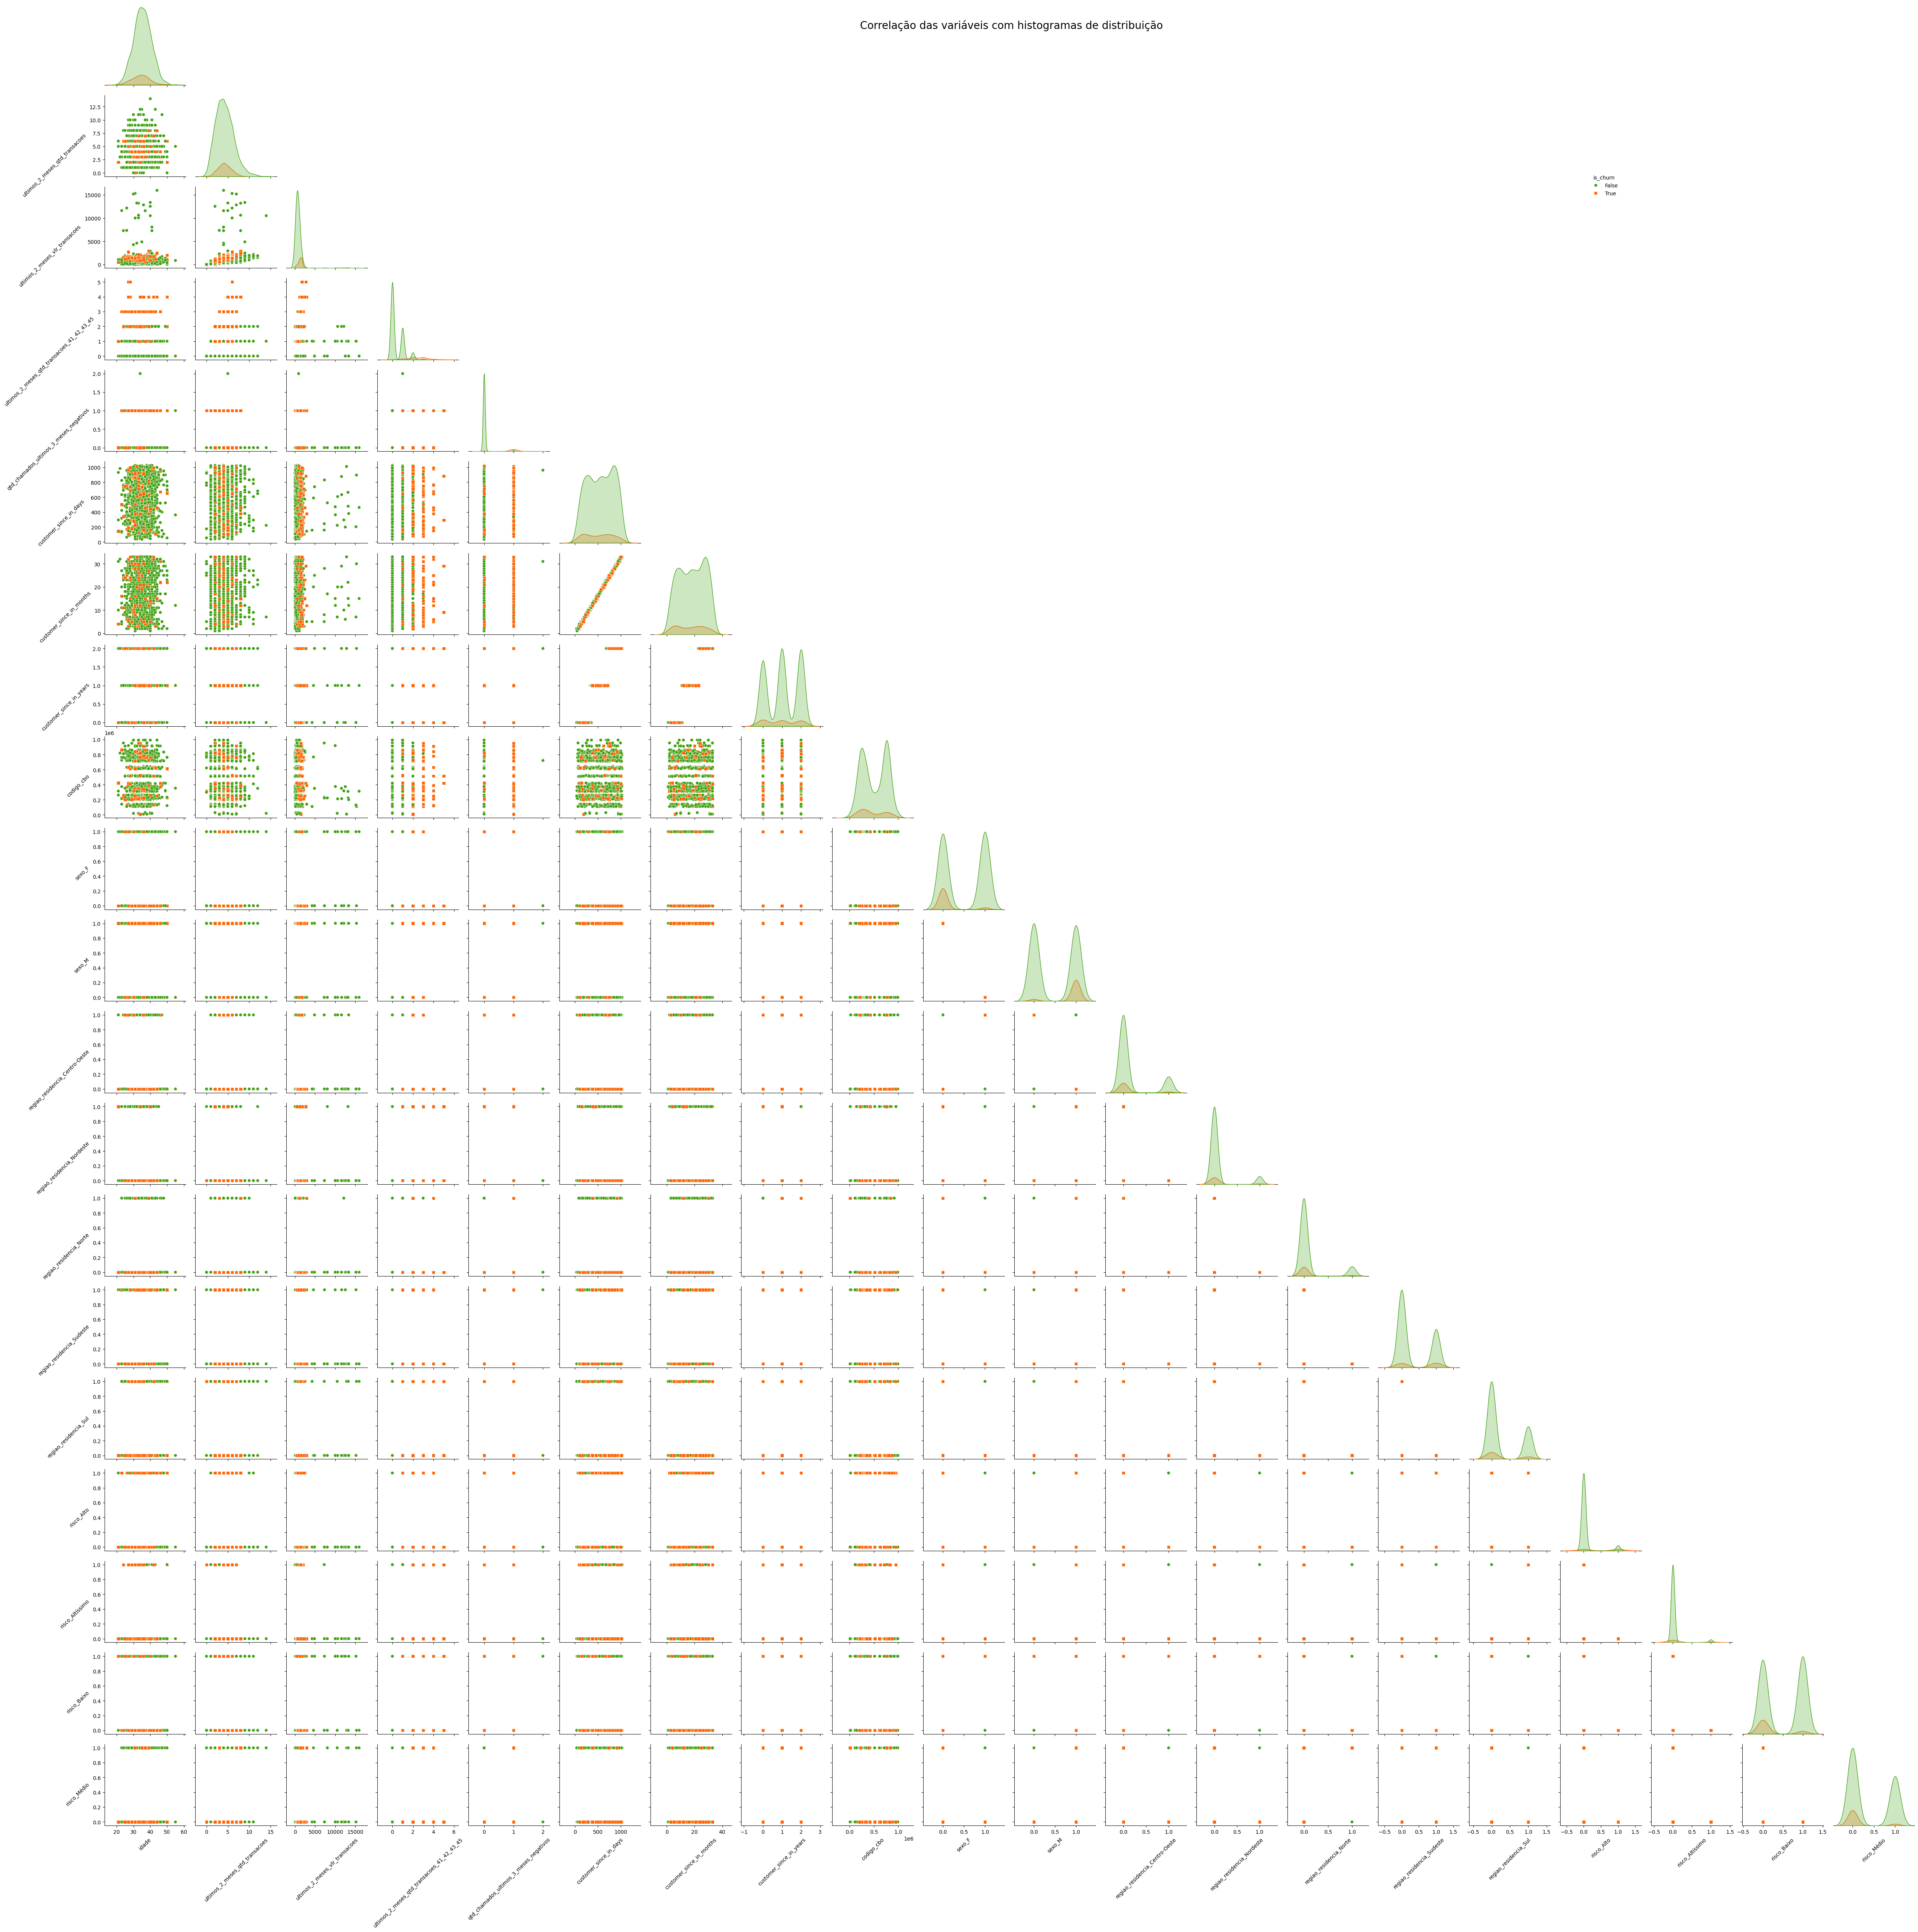

In [31]:
g = sns.pairplot(
    df[columns_plot],
    hue="is_churn",
    markers=["o", "s"],
    palette=palette_pairplot,
    corner=True,
    hue_order=[False, True]
)

for ax in g.axes.flatten():
    if not ax:
        continue
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 45)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 45)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.8, 0.9))
g.fig.suptitle("Correlação das variáveis com histogramas de distribuição", fontsize=20)
plt.show()

## Matriz de correlação

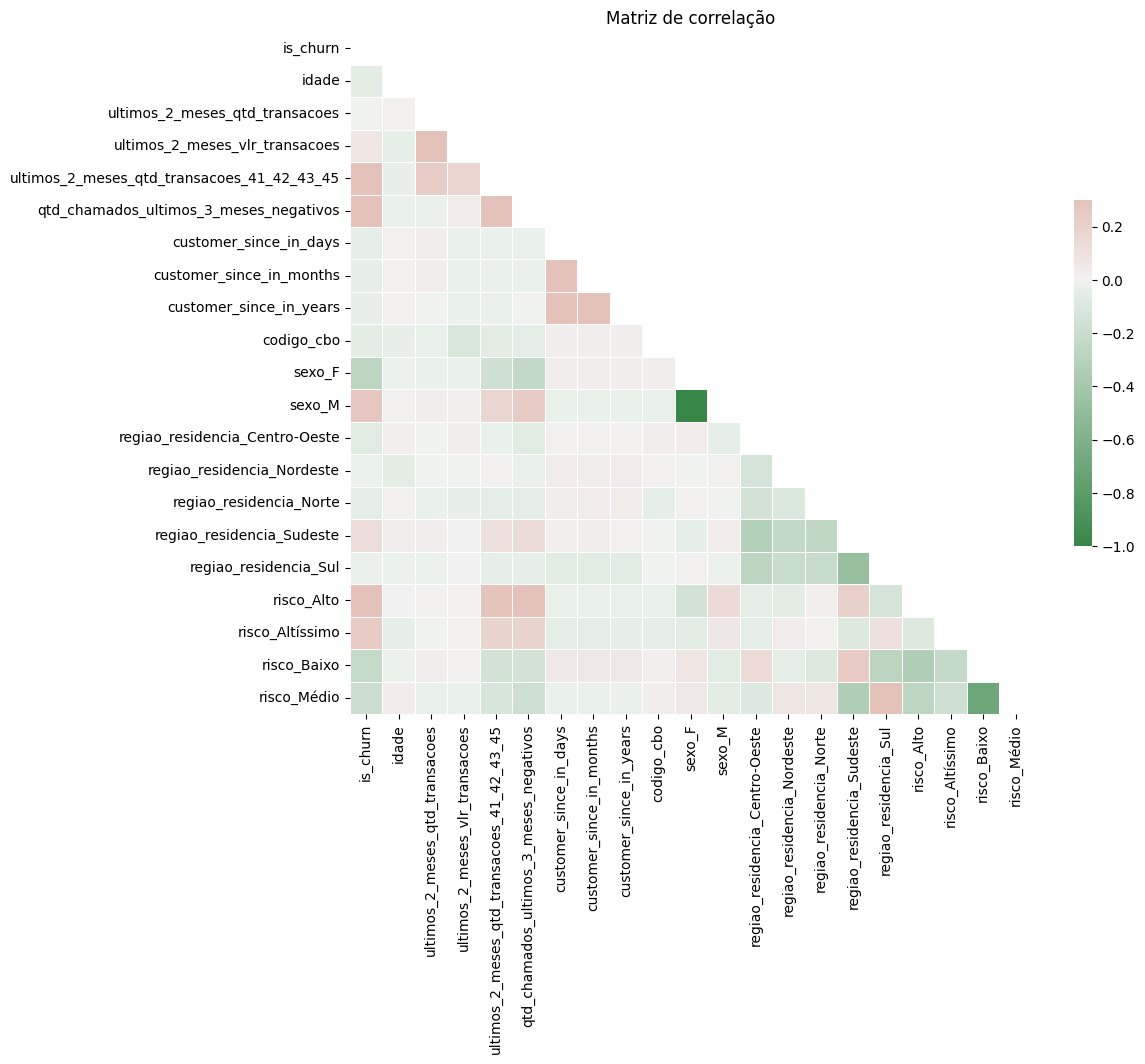

In [32]:
# Gerando o dataframe das correlações
df_corr = df[columns_plot].corr()

# Gerando uma matriz de cores custommizada
cmap = sns.diverging_palette(133, 20, as_cmap=True)

# Gerando uma máscara para remover a borda da matriz
mask = np.triu(np.ones_like(df_corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Matriz de correlação')
plt.show()

## Comparativo da base ativa com a base de CHURN

A base é composta por 1100 associados que possuem até 2 anos e 8 meses de relacionamento com o Sicredi. Desses associados, 88.91% permanece ativio na base e 11.09% deu CHURN.

Durante a análise foram observados:

- Dados de gerais do associado
- Chamados dos últimos 3 meses
- Transações dos últimos 2 meses



In [33]:
df_aux = df[['id_associado','is_churn']].groupby(['is_churn']).agg({'id_associado': 'count'}).reset_index().rename(columns={'id_associado':'total'})
df_aux['perc'] = df_aux['total']/df_aux['total'].sum() * 100
df_aux['is_churn'] = df_aux['is_churn'].map({True: 'Sim', False: 'Não'})

fig = px.bar(df_aux, x="is_churn", y="perc", color="is_churn", title="Comparativo da base ativa com a base de CHURN", color_discrete_sequence=palette_plotly, labels={'is_churn': 'É CHURN?', 'perc':'Valor %'}, text_auto='.2f')
fig.update_layout(
    legend=dict(
        title='É CHURN?'
    )
)

fig.show()

/tmp/ipykernel_26370/1217574595.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_aux = df[['id_associado','is_churn']].groupby(['is_churn']).agg({'id_associado': 'count'}).reset_index().rename(columns={'id_associado':'total'})


## Relação do CHURN com a região de residência

O CHURN acompanha a proporção da base de clientes por região


In [35]:
df_aux = df[['id_associado','is_churn', 'regiao_residencia']].groupby(['is_churn', 'regiao_residencia']).agg({'id_associado': 'count'}).reset_index().rename(columns={'id_associado':'total'})
df_aux['perc'] = df_aux['total']/df_aux['total'].sum() * 100
df_aux['is_churn'] = df_aux['is_churn'].map({True: 'Sim', False: 'Não'})

fig = px.bar(df_aux, x="regiao_residencia", y="perc", color="is_churn", title="Relação do CHURN com a região de residência", color_discrete_sequence=palette_plotly, labels={'regiao_residencia': 'Região de residência', 'perc':'Valor %'}, text_auto='.2f')
fig.update_layout(
    legend=dict(
        title='É CHURN?'
    )
)

fig.show()

/tmp/ipykernel_26370/2086414713.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Relação do CHURN com o tempo ativo na base

A maior concentração de CHURN acontece entre o 5 e 9 mês e no 20 ao 24 mês de relação de associado, representando aproximadamente 19% da base de clientes desses intervalos.

In [127]:
df_aux = df[['id_associado','customer_since_in_months', 'is_churn']]
df_aux['is_churn'] = df_aux['is_churn'].map({True: 'Sim', False: 'Não'})

fig = px.histogram(df_aux, x="customer_since_in_months", color="is_churn", nbins=10, title="Relação do CHURN com o tempo ativo na base (em meses)", color_discrete_sequence=palette_plotly, histnorm='percent', labels={'customer_since_in_months': 'Tempo ativo na base em meses'},  text_auto='.2f')

fig.update_layout(
    yaxis_title="Valor %",
    legend=dict(
        title='É CHURN?'
    )
)
fig.show()

/tmp/ipykernel_26370/1590021361.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Relação do CHURN com o risco

A maior proporção de CHURN é a de associados com risco alto.

In [36]:
df_aux = df[['id_associado','is_churn', 'risco']].groupby(['is_churn', 'risco']).agg({'id_associado': 'count'}).reset_index().rename(columns={'id_associado':'total'})
df_aux['perc'] = df_aux['total']/df_aux['total'].sum() * 100
df_aux['is_churn'] = df_aux['is_churn'].map({True: 'Sim', False: 'Não'})

fig = px.bar(df_aux, x="risco", y="perc", color="is_churn", title="Relação do CHURN com o risco", color_discrete_sequence=palette_plotly, labels={'risco': 'Risco', 'perc':'Valor %'}, text_auto='.2f')
fig.update_layout(
    legend=dict(
        title='É CHURN?'
    )
)
fig.show()

/tmp/ipykernel_26370/210120161.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Relação do risco e idade

É preciso tomar cuidado ao realizar ações baseadas na idade pois pode ser uma forma de causar discriminação por etarismo.

A maior concentração de CHURN é de pessoas com idade entre 30 e 40 anos.

A soma do CHURN do risco alto e altíssimo ultrapassam 55% da base de clientes com idade de 30 a 40 anos.



In [126]:
df_aux = df.loc[df['is_churn']==True][['id_associado','risco', 'idade']]
fig = px.histogram(df_aux, x="idade", color="risco", nbins=10, title="Relação do gênero e idade na base de clientes que deram CHURN", histfunc='count', histnorm='percent', color_discrete_sequence=palette_risk, labels={'idade': 'Idade'}, text_auto='.2f')

fig.update_layout(
    yaxis_title="Valor %",
    legend=dict(
        title='Risco'
    )
)
fig.show()

## Relação do CHURN com o gênero

Antes de inciar a análise é importante destacar que o gênero é um dado sensível e pode gerar discriminação algorítimica. Por isso é preciso ter muito cuidade ao utilizar esse tipo de dado nos modelos de aprendizado de máquina.

Esse dado é importante no ponto de vista analítico, mas não deve ser utilizado em ações da empresa como forma de discriminação.

In [37]:
df_aux = df[['id_associado','is_churn', 'sexo']].groupby(['is_churn', 'sexo']).agg({'id_associado': 'count'}).reset_index().rename(columns={'id_associado':'total'})
df_aux['perc'] = df_aux['total']/df_aux['total'].sum() * 100
df_aux['is_churn'] = df_aux['is_churn'].map({True: 'Sim', False: 'Não'})

fig = px.bar(df_aux, x="sexo", y="perc", color="is_churn", title="Relação do CHURN com o gênero", color_discrete_sequence=palette_plotly, labels={'sexo': 'Gênero', 'perc':'Valor %'}, text_auto='.2f')
fig.update_layout(
    legend=dict(
        title='É CHURN?'
    )
)
fig.show()

/tmp/ipykernel_26370/943836449.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Relação do gênero e risco na base de clientes que deram CHURN

- Homens de risco alto represemtam o maior volume de CHURN, com 57.14%
- Das mulheres que deram CHURN, todas fazem parte do risco baixo.

In [39]:
df_aux = df.loc[df['is_churn']==True][['id_associado','sexo', 'risco']]
fig = px.histogram(df_aux, x="risco", color="sexo", title="Relação do gênero e risco na base de clientes que deram CHURN", histfunc='count', histnorm='percent', color_discrete_sequence=palette_is_churn_gen, labels={'risco': 'Risco'}, text_auto='.2f')

fig.update_layout(
    yaxis_title="Valor %",
    legend=dict(
        title='Gênero'
    )
)
fig.show()

### Relação do gênero e risco na base de clientes ativos

A base de clientes ativos é proporcional por gênero e apresenta mais clientes com risco baixo e médio.

In [40]:
df_aux = df.loc[df['is_churn']==False][['id_associado','sexo', 'risco']]
fig = px.histogram(df_aux, x="risco", color="sexo", title="Relação do gênero e risco na base de clientes ativos", histfunc='count', histnorm='percent', color_discrete_sequence=palette_not_churn_gen, labels={'risco': 'Risco'}, text_auto='.2f')

fig.update_layout(
    yaxis_title="Valor %",
    legend=dict(
        title='Gênero'
    )
)
fig.show()

## Relação da transações dos últimos 2 meses e do risco

Não consegui idenficar uma diferença significativa de comportamento entre os clientes ativos e os em CHURN quando se trata da relação risco e quantidade ou valor de transações.

O que pude perceber foi que na base de clientes ativos existem mais outliers para valores de transação acima de R$2k.



In [117]:
df_aux = df[['id_associado','ultimos_2_meses_qtd_transacoes', 'risco', 'is_churn']]
fig = px.box(df_aux, x="ultimos_2_meses_qtd_transacoes", color="risco", facet_col='is_churn', category_orders=risk_category_orders, title="Relação da quantidade de transações e do risco", color_discrete_sequence=palette_risk, labels={'ultimos_2_meses_qtd_transacoes': 'Total de transações dos últimos 2 meses por cliente'})

fig.update_layout(
    yaxis_title="Total de clientes",
    legend=dict(
        title='Risco'
    )
)
fig.show()

In [118]:
category_orders={"risco": ["Baixo", "Médio", "Alto", "Altíssimo"]}


df_aux = df[['id_associado','ultimos_2_meses_vlr_transacoes', 'risco', 'is_churn']]
fig = px.box(df_aux, x="ultimos_2_meses_vlr_transacoes", color="risco", facet_col='is_churn', category_orders=risk_category_orders, title="Relação do valor das transações e do risco", color_discrete_sequence=palette_risk, labels={'ultimos_2_meses_vlr_transacoes': 'Valor das transações dos últimos 2 meses por cliente'})

fig.update_layout(
    yaxis_title="Total de clientes",
    legend=dict(
        title='Risco'
    )
)
fig.show()

## Relação do volume de chamados e do risco

Clientes em potencial de CHURN podem abrir mais chamados que os clientes com potencial de permanecerem ativos.

In [133]:
category_orders={"risco": ["Baixo", "Médio", "Alto", "Altíssimo"]}


df_aux = df[['id_associado','qtd_chamados_ultimos_3_meses_negativos', 'risco', 'is_churn']]
fig = px.histogram(df_aux, x="qtd_chamados_ultimos_3_meses_negativos", color="risco", facet_col='is_churn', category_orders=risk_category_orders, nbins=10, title="Relação do volume de chamados e do risco", color_discrete_sequence=palette_risk, labels={'qtd_chamados_ultimos_3_meses_negativos': 'Total de chamados dos últimos 3 meses por cliente'})

fig.update_layout(
    yaxis_title="Total de clientes",
    legend=dict(
        title='Risco'
    )
)
fig.show()

# Análise preditiva

## Preparação do DataFrame preditivo

Seleção dos atributos números e categórios (com OneHotEncode aplicado) a partir do DataFrame analítico.

In [44]:
churn_column = ['is_churn']
numeric_columns = [
    'idade', 
    'ultimos_2_meses_qtd_transacoes', 'ultimos_2_meses_vlr_transacoes', 'ultimos_2_meses_qtd_transacoes_41_42_43_45',
    'qtd_chamados_ultimos_3_meses_negativos',
    'customer_since_in_days', 'customer_since_in_months', 'customer_since_in_years',
    'codigo_cbo'
]
categorical_columns = list(df_encode.columns)
predictive_columns = churn_column + numeric_columns + categorical_columns
df_predictive = df[predictive_columns].copy()
df_predictive['is_churn'] = df_predictive['is_churn'].astype('int')
df_predictive

,is_churn,idade,ultimos_2_meses_qtd_transacoes,ultimos_2_meses_vlr_transacoes,ultimos_2_meses_qtd_transacoes_41_42_43_45,qtd_chamados_ultimos_3_meses_negativos,customer_since_in_days,customer_since_in_months,customer_since_in_years,codigo_cbo,...,sexo_M,regiao_residencia_Centro-Oeste,regiao_residencia_Nordeste,regiao_residencia_Norte,regiao_residencia_Sudeste,regiao_residencia_Sul,risco_Alto,risco_Altíssimo,risco_Baixo,risco_Médio
0,0,35,4,765,0,0,479,16,1,225165,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,34,4,370,1,0,939,31,2,312105,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0,34,2,573,0,0,1004,33,2,841505,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,24,8,7290,1,0,244,8,0,953110,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0,34,5,1244,0,0,426,14,1,121010,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1,30,5,1416,3,1,281,9,0,322120,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1096,1,31,6,1345,3,1,504,16,1,252540,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1097,1,42,7,1718,4,1,993,33,2,517210,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1098,1,33,4,1490,3,1,752,24,2,950110,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Divisão do conjunto de dados em treino e teste

A divisão do conjunto de dados será feita apenas em treino e teste, pois irei utilizar validação cruzada durante o treinamento.
O conjunto de treinamento deve ter 70% dos dados e o de teste 30% dos dados. A divisão considera a divisão a partir da classe `is_churn`. Isso quer dizer que o conjunto de treinamento terá 70% dos dados de clientes em CHURN e o de teste 30% dos dados de clientes em CHURN.

In [45]:
df_train, df_test = train_test_split(
    df_predictive, 
    test_size=0.3, 
    random_state=42,
    shuffle=True,
    stratify=df_predictive['is_churn']
)
print(df_train.shape, df_test.shape)

(770, 21) (330, 21)


## Aplica normalização nos dados de treino e teste

A normalização está sendo aplicada utilizando a classe MinMaxScaler que padroniza os dados numa escala de 0 e 1.

In [46]:
X_columns = numeric_columns + categorical_columns

df_X_train = df_train[X_columns].reset_index(drop=True)
df_y_train = df_train['is_churn'].reset_index(drop=True)

df_X_test = df_test[X_columns].reset_index(drop=True)
df_y_test = df_test['is_churn'].reset_index(drop=True)

scaler = CustomScaler().fit(df_X_train, MinMaxScaler).save('MinMaxScaler')
df_X_train_scaled = scaler.transform(df_X_train)
df_X_test_scaled = scaler.transform(df_X_test)

## Realiza estudo de PCA e aplica transformação para retornar as componentes dos conjuntos de treino e teste

A análise de PCA está sendo utilizada como um método de seleção de features a fim de reduzir a dimensão do conjunto de dados. A seleção é feita considerando de 95% dos compoenentes principais que conseguem explicar a variabilidade de todo o conjunto de dados. O percentual de explicabilidade é configurável.

Total de features = 20
Total de componentes = 9


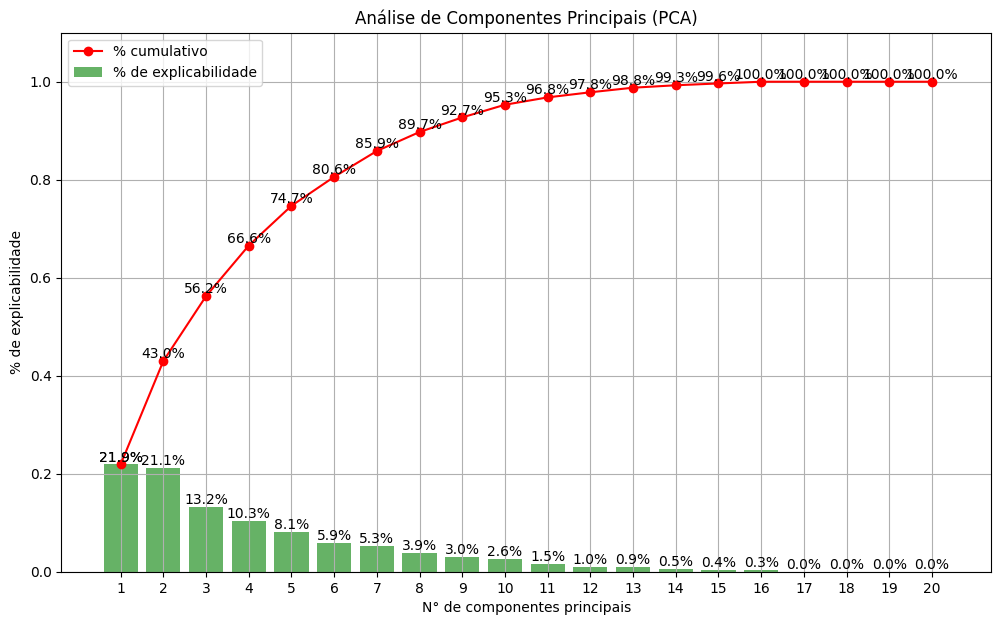

In [47]:
pca_study = CustomPCA().fit(df_X_train_scaled)
df_X_pca_study = pca_study.transform(df_X_train_scaled)
n_components = pca_study.get_n_components(0.95)
print(f'Total de features = {df_X_train_scaled.shape[1]}')
print(f'Total de componentes = {n_components}')

pca_study.plot_pca(df_X_train_scaled)

pca = CustomPCA().fit(df_X_train_scaled, n_components).save('PCAModel')
df_X_train_pca = pca.transform(df_X_train_scaled)
df_X_test_pca = pca.transform(df_X_test_scaled)

## Treinamento dos modelos com otimização dos hiperparâmetros utilizando a estrutura **multi objective** do Optuna


A estrutura **multi objetive** busca otimizar mais de uma métrica de avaliação de desempenho dos modelos.

Aqui estamos chamando a classe `ClassifierOptimizerMultiObjective` que encapsula a utilização do optuna e o treinamento do modelo com melhor desempenho para a acurácia, precision, recall e f1 score da tarefa de classificação do dataset da análise preditiva de CHURN do cartão de crédito.

É importante destacar que o classificador está utilizando a técnica de validação cruzada durante o treinamento. O otimizador está olhando para a média das métricas geradas a partir do conjunto de validação.

Para o pipeline de treinamento foram considerados os seguintes algoritmos de machine learning:
- Regressão Logística
- SVM
- Árvore de decisão
- RandomForest
- LightGBM
- CatBoost

O optuna irá retornar o modelo que tiver o melhor desempenho.

O pipeline de otimização de hiperparâmetros com o Optuna poderia ter sido trabalhado em conjunto com o MLFlow para fazer o tracking das métricas a fim de comparar o melhor modelo com os demais. Mas esse ponto será tratado em uma próxima versão.

#### Execução do treinamento com a otimização dos hiperparâmetros com o objeto ClassifierOptimizerMultiObjective

Retorna o estudo com o melhor modelo treinado e seus parâmetros. Além disso, retorna as métricas do conjunto de validação.

In [48]:
#Execução da otimização dos hiperparâmetros com o objeto ClassifierOptimizerMultiObjective

X_train = df_X_train_pca.copy()
y_train = df_y_train.copy()

classifier_optimizer_mo = ClassifierOptimizerMultiObjective(
    n_trials=5,
    timeout=600,
    n_jobs=-1,
    k_folds=5,
)
study_mo = classifier_optimizer_mo.get_study()
best_model_mo = classifier_optimizer_mo.fit(X=X_train, y=y_train)

[I 2024-06-24 08:32:48,222] Using an existing study with name 'classifier_muiltiple_objective_study' instead of creating a new one.
[W 2024-06-24 08:32:49,034] Trial 36 failed with parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 244, 'rf_max_depth': 32, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 10, 'rf_max_features': 'log2', 'rf_min_weight_fraction_leaf': 2.0108307219899732e-05, 'rf_max_samples': 0.8060676605520205, 'rf_criterion': 'entropy'} because of the following error: AttributeError("'RandomForestClassifier' object has no attribute 'estimators_'").
Traceback (most recent call last):
  File "/home/marilia/git/churn/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_26370/125129280.py", line 86, in <lambda>
    objective_wrap_func = lambda trial: self._objective(
  File "/tmp/ipykernel_26370/125129280.py", line 214, in _objective
    if not classifier_obj:
  File "/home

[LightGBM] [Info] Number of positive: 68, number of negative: 548
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1853
[LightGBM] [Info] Number of data points in the train set: 616, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110390 -> initscore=-2.086768
[LightGBM] [Info] Start training from score -2.086768
0:	learn: 0.6642138	total: 52.3ms	remaining: 9.99s
1:	learn: 0.6350522	total: 56.7ms	remaining: 5.39s
0:	learn: 0.6606590	total: 51.5ms	remaining: 9.85s
2:	learn: 0.6065322	total: 58.3ms	remaining: 3.67s
1:	learn: 0.6378048	total: 66.4ms	remaining: 6.31s
3:	learn: 0.5845570	total: 77.2ms	remaining: 3.63s
4:	learn: 0.5589519	total: 78.6ms	remaining: 2.94s
2:	learn: 0.6083515	total: 75.4ms	remaining: 4.75s
5:	learn: 0.5365534	total: 81.4ms	remaining: 2.52s
6:	learn: 0.5141923	total: 91ms	remaining: 2.4s
3:	lear

[I 2024-06-24 08:32:55,606] Trial 35 finished with values: [0.9714285714285713, 0.9491159214955684, 0.9066552168312582, 0.9239197455294963] and parameters: {'classifier': 'Catboost', 'iterations': 192, 'learning_rate': 0.03761514757115043, 'depth': 6, 'l2_leaf_reg': 0.00023796953410454088, 'bootstrap_type': 'Bayesian', 'random_strength': 4.4091636590487486e-05, 'bagging_temperature': 9.668802652077988, 'od_type': 'IncToDec', 'od_wait': 48}. 


70:	learn: 0.0029218	total: 1.33s	remaining: 9.69s
71:	learn: 0.0027207	total: 1.34s	remaining: 9.56s
5:	learn: 0.1660997	total: 77.4ms	remaining: 7.5s
72:	learn: 0.0026202	total: 1.34s	remaining: 9.44s
73:	learn: 0.0025416	total: 1.34s	remaining: 9.31s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
74:	learn: 0.0025017	total: 1.34s	remaining: 9.19s
75:	learn: 0.0023875	total: 1.35s	remaining: 9.06s
76:	learn: 0.0023199	total: 1.35s	remaining: 8.95s
77:	learn: 0.0022477	total: 1.35s	remaining: 8.83s
78:	learn: 0.0021431	total: 1.35s	remaining: 8.72s
79:	learn: 0.0020941	total: 1.36s	remaining: 8.61s
80:	learn: 0.0020237	total: 1.36s	remaining: 8.51s
81:	learn: 0.0019526	total: 1.36s	remaining: 8.4s
82:	learn: 0.0018719	total: 1.37s	remaining: 8.3s
83:	learn: 0.0018018	total: 1.37s	remaining: 8.2s
84:	learn: 0.0017379	total: 1.37s	remaining: 8.1s
85:	learn: 0.0016808	total: 1.37s	remaining: 8.01s
86:	learn: 0.0016292	total: 1.38s	remaining: 7.92s
61:	learn: 0

[I 2024-06-24 08:33:07,359] Trial 37 finished with values: [0.9831168831168832, 0.9683557371090934, 0.9492915414340917, 0.9565082843961992] and parameters: {'classifier': 'Catboost', 'iterations': 587, 'learning_rate': 0.04572412152931411, 'depth': 6, 'l2_leaf_reg': 0.0008775343287192507, 'bootstrap_type': 'Bayesian', 'random_strength': 1.2746065890868e-06, 'bagging_temperature': 5.397766907298226, 'od_type': 'IncToDec', 'od_wait': 17}. 


575:	learn: 0.0000336	total: 4.65s	remaining: 88.7ms
576:	learn: 0.0000336	total: 4.65s	remaining: 80.6ms
577:	learn: 0.0000336	total: 4.65s	remaining: 72.4ms
578:	learn: 0.0000336	total: 4.66s	remaining: 64.4ms
579:	learn: 0.0000336	total: 4.66s	remaining: 56.3ms
580:	learn: 0.0000336	total: 4.67s	remaining: 48.2ms
581:	learn: 0.0000336	total: 4.67s	remaining: 40.1ms
582:	learn: 0.0000336	total: 4.67s	remaining: 32.1ms
583:	learn: 0.0000336	total: 4.67s	remaining: 24ms
584:	learn: 0.0000336	total: 4.67s	remaining: 16ms
585:	learn: 0.0000336	total: 4.68s	remaining: 7.98ms
586:	learn: 0.0000336	total: 4.68s	remaining: 0us
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-06-24 08:33:12,284] Trial 38 finished with values: [0.9753246753246753, 0.9409864961247452, 0.9346071275225419, 0.9365635432684902] and parameters: {'classifier': 'LightGBM', 'lg_boosting_type': 'gbdt', 'lg_num_leaves': 86, 'lg_max_depth': 44, 'lg_learning_rate': 0.0659100112556443, 'lg_n_estimators': 93, 'lg_min_child_samples': 5, 'lg_colsample_bytree': 0.8454973935341255}. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

#### Informações sobre o melhor trial

Apresenta:
- Número do trial
- Melhores parâmetros
- Métricas de avaliação do conjuto de treinamento: accuracy, precision, recall, f1

In [93]:
print(f"Best number: {study_mo.best_trials[0].number}")
print("\n\nBest params\n", study_mo.best_trials[0].params)
print("\n\nBest value\n", study_mo.best_trials[0].values)

Best number: 5


Best params
 {'classifier': 'LightGBM', 'lg_boosting_type': 'gbdt', 'lg_num_leaves': 92, 'lg_max_depth': 65, 'lg_learning_rate': 0.03625416340355061, 'lg_n_estimators': 241, 'lg_min_child_samples': 31, 'lg_colsample_bytree': 0.9186108776794135}


Best value
 [0.9883116883116884, 0.9882337777434742, 0.9883116883116884, 0.9881187182382835]


In [94]:
study_mo.best_trials[0].params.get('classifier')

'LightGBM'

#### Resultado da classificação para o conjunto de teste utilizando o best model da função multi objective

In [108]:
# Resultado da classificação para o conjunto de teste utilizando o best model da função multi objective
X_test = df_X_test_pca.copy()
y_test = df_y_test.copy()


classifier = best_model_mo

# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Predict probabilities
probs_y = classifier.predict_proba(X_test)

y_true = y_test

df_y_true_pred = pd.DataFrame({
    'y_true': y_true, 
    'y_pred': y_pred, 
    '0': probs_y[:,0], 
    '1': probs_y[:,1], 
})

Text(0.5, 1.0, 'Matriz de confusão')

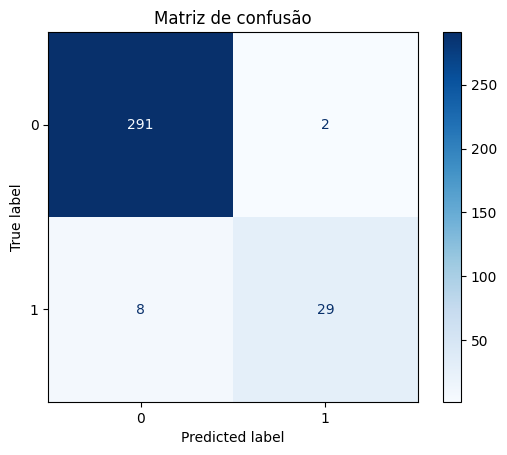

In [109]:
disp = ConfusionMatrixDisplay.from_estimator(
    classifier,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
)
disp.ax_.set_title("Matriz de confusão")

In [110]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
df_test_metrics = pd.DataFrame([accuracy, precision, recall, f1], index=['test_accuracy', 'test_precision', 'test_recall', 'test_f1']).T

In [111]:
df_val_metrics = pd.DataFrame(study_mo.best_trials[0].values, index=['val_accuracy', 'val_precision', 'val_recall', 'val_f1']).T
df_val_metrics

,val_accuracy,val_precision,val_recall,val_f1
0,0.988312,0.988234,0.988312,0.988119


In [112]:
df_metrics = pd.concat([df_val_metrics, df_test_metrics], ignore_index=False, axis=1)
df_metrics

,val_accuracy,val_precision,val_recall,val_f1,test_accuracy,test_precision,test_recall,test_f1
0,0.988312,0.988234,0.988312,0.988119,0.969697,0.935484,0.783784,0.852941


# Comparação das métricas de desempenho dos modelos

Durante a fase de experimentação, os modelos abaixo foram testados. No entando o que teve melhor desempenho foi o LightGBM.
- Regressão Logística
- SVM
- Árvore de decisão
- RandomForest
- LightGBM
- CatBoost

O LightGBM conseguiu ter uma boa generalização para todas as métricas analisadas para o problema de classificação binária do CHURN de cartão de crédito.

O gráfico apresenta a comparação das métricas do conjunto de validação e teste.


O modelo classifica se o cliente tem potencial de dar CHURN ou não. No geral, a primeira versão apresentou um bom desempenho.
- Consegue classificar corretamente a classe dos novos dados em ~96%
- Consegue balancear os erros de classificação de falso positivo e falso negativo em ~85% para dados novos
- Ainda é preciso melhorar o desempenho do recall pois alguns casos de CHURN podem não ser considerados como CHURN pelo modelo

Sobre as métricas:
- Acurácia: Total de classificações corretas
- Precision: Dos dados classificados como CHURN quais realmente são CHURN
- Recall: Dos dados que deveriam ser classificados como CHURN quais realmente foram identificadas CHURN
- F1: Média harmônica entre precision e recall



In [113]:
classifier_name = study_mo.best_trials[0].params.get('classifier')
metrics = ['accuracy', 'precision', 'recall', 'f1']

val_y = df_val_metrics.values.flatten()*100
test_y = df_test_metrics.values.flatten()*100

fig = go.Figure()
fig.add_trace(
    go.Bar(name='Validação', x=metrics, y=val_y, marker_color='#64C832', text=val_y)
)
fig.add_trace(
    go.Bar(name='Teste', x=metrics, y=test_y,  marker_color='#146E37', text=test_y)
)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='auto')
fig.update_layout(
    barmode='group',
    title_text=f'Comparação das métricas do modelo {classifier_name}',
)
fig.show()

# Próximos passos

- Acompanhamento das métricas do modelo com os novos casos de CHURN
- Compreender os pontos de melhoria do modelo
    - Retornar um valor percentual do possível CHURN no resultado do modelo
    - Melhoria no encode de dados categóricos com muitas classes
- Enriquecimento dos dados da base utilizada
    - Exploração dos dados de chamados e de transações financeiras
    - Entender relação do CNAE com as ações dos associados
- Identificar tópicos de assuntos tratados nos chamados
- Realizar uma análise de personas
- Produtização da primeira versão com um pipeline de ferramentas MLOps
